# Entity Matching for Online Marketplaces



## What is Entity Matching (EM)?

## Why is EM needed for online marketplaces?

## Exploratory Data Analysis

### Dataset Origin

### Offer Features

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from IPython.display import display, HTML

import warnings
# warnings.filterwarnings('ignore')

# load custom functions
# os.chdir('C:/Users/kyleg/Entity-Matching-in-Online-Retail')
os.chdir('H:/kgilde/Entity-Matching-in-Online-Retail')
exec(open("utility_functions.py").read())

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [39]:
# Load Data
DATA_DIRECTORY = '//files/share/goods/OI Team'

os.chdir(DATA_DIRECTORY)

train_test_feature_pairs = pd.read_csv('train_test_feature_pairs.csv')
train_test_offer_features = pd.read_csv('train_test_offer_features.csv')
train_test_normalized_features = pd.read_csv('train_test_normalized_features.csv')


In [119]:
PLOT_DIRECTORY = '//files/share/goods/OI Team/plots'
SHORT_TEXT_FEATURES = ['gtin', 'mpn', 'sku', 'identifier', 'brand', 'manufacturer']
PRODUCT_IDENTIFIERS = ['gtin', 'mpn', 'sku', 'identifier']
BRAND_MANUFACTURER =  ['brand', 'manufacturer']
MEDIUM_LONG_TEXT_FEATURES = ['name', 'description']
OTHER_FEATURES = ['category', 'price']
ALL_FEATURES = SHORT_TEXT_FEATURES + MEDIUM_LONG_TEXT_FEATURES + OTHER_FEATURES
  
test_ids = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                    (train_test_feature_pairs.dataset == 'test')]\
                [['offer_id_1', 'offer_id_2']]\
                .stack()\
                .unique()
    
train_test_offer_features_only = train_test_offer_features[ALL_FEATURES]
test_offer_features_only = train_test_offer_features.loc[train_test_offer_features.offer_id.isin(test_ids), ALL_FEATURES]

os.chdir(PLOT_DIRECTORY)

### Top Domains

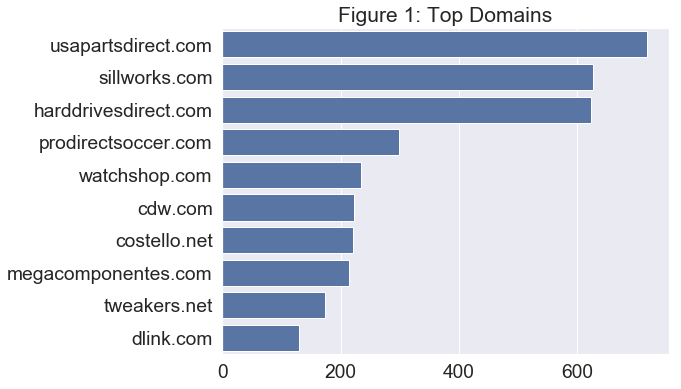

In [8]:
domains = train_test_offer_features.domain.str.replace('www\.|de\.', '')\
    .value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.75)

sns.barplot(x=domains.values, y=domains.index, 
            color="b")\
            .set_title('Figure 1: Top Domains')

plt.savefig('fig-01-top-domains.png', bbox_inches = "tight")


### Sparsity

In [ ]:
null_percentages = calculate_percent_nulls(train_test_offer_features_only, print_series=False, return_series=True)
nulls_by_index = train_test_offer_features[null_percentages.index].isnull().T

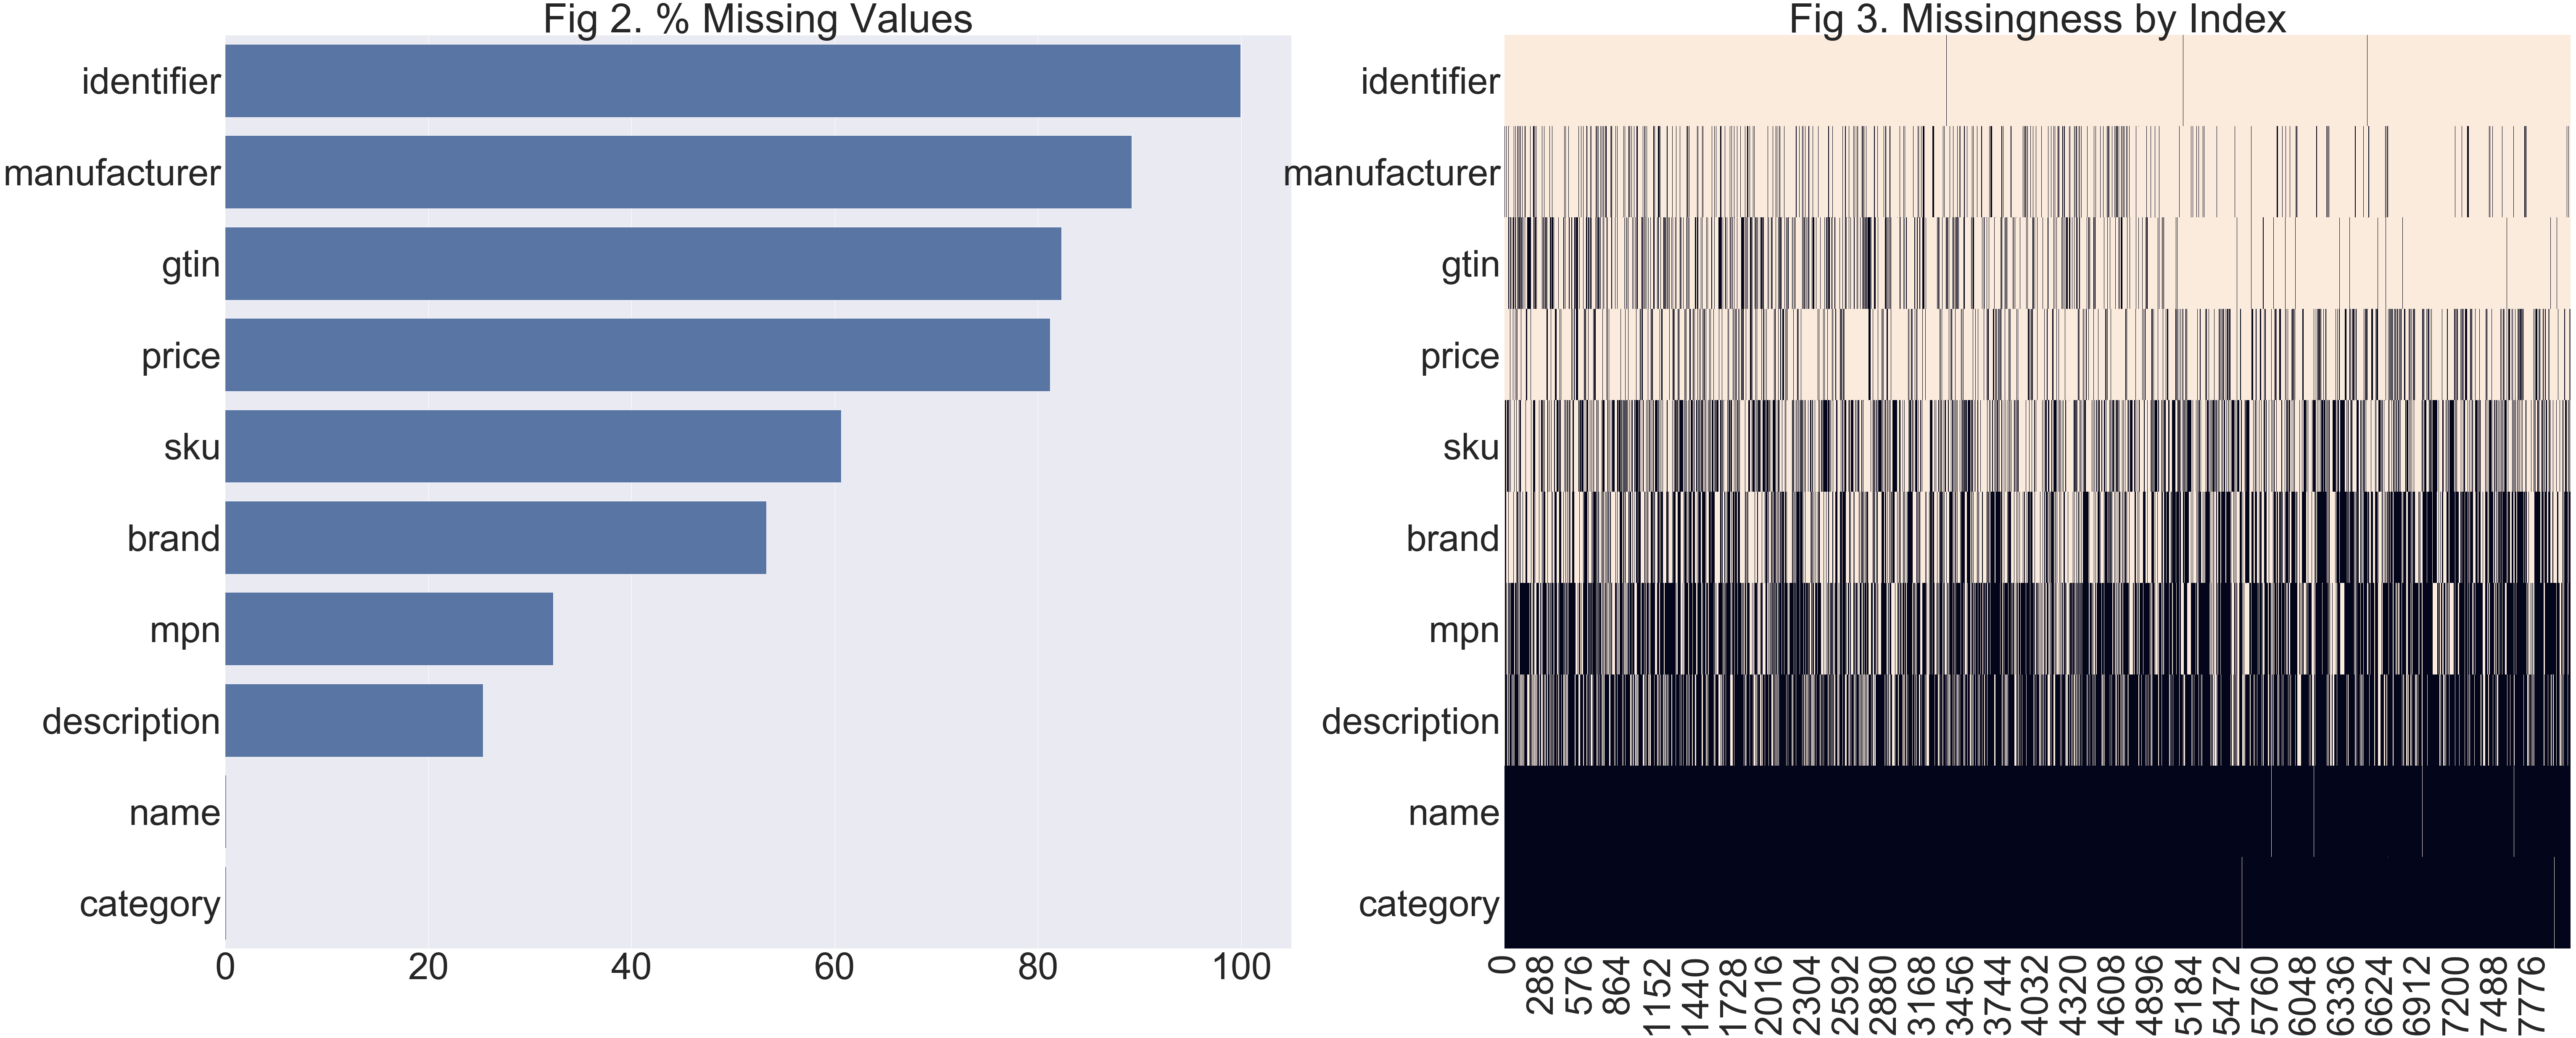

In [34]:
sns.set(font_scale=8)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(100, 40))

sns.barplot(x=null_percentages.values, 
            y=null_percentages.index, 
            color="b", 
            ax=axes[0])\
            .set_title('Fig 2. % Missing Values')

sns.heatmap(nulls_by_index, 
            cbar=False, 
            ax=axes[1])\
            .set_title('Fig 3. Missingness by Index')

fig.savefig("fig-02-03-feature-sparsity.png", bbox_inches = "tight")

## Features

### Short Text Character Lengths

In [45]:
# count chararters for short-text features
# identifiers_features = train_test_normalized_features[PRODUCT_IDENTIFIERS]
# char_counts_identifiers_features = identifiers_features.apply(lambda s: s.str.len(), axis=1)
short_text_features = train_test_normalized_features[SHORT_TEXT_FEATURES]
char_counts_df = short_text_features.apply(lambda s: s.str.len(), axis=1)

In [48]:
char_counts_df.median()

gtin            12.0
mpn              9.0
sku              9.0
identifier       9.0
brand           13.0
manufacturer     7.0
dtype: float64

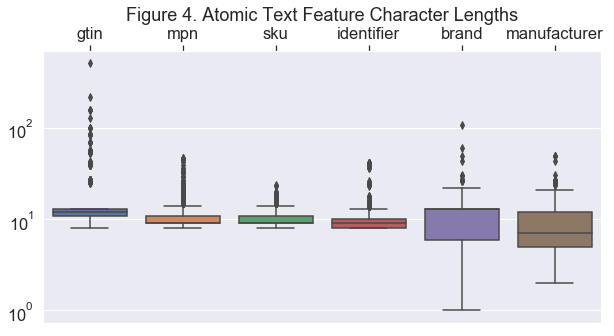

In [51]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.5)

ax = sns.boxplot(data = char_counts_df)
ax.set_title('Figure 4. Atomic Text Feature Character Lengths')
ax.xaxis.tick_top()
ax.set(yscale='log')

# plt.figure(figsize=(10, 5))
# sns.set(font_scale=1.5)

# ax = sns.boxplot(data = char_counts_identifiers_features)
# ax.set_title('Figure 4. Product Identifier Character Lengths')
# ax.xaxis.tick_top()
# ax.set(yscale='log')

plt.savefig("fig-04-character-lengths.png", bbox_inches = "tight")

### Top Brands & Manufacturers

In [52]:
top_values =\
    train_test_normalized_features[['brand', 'manufacturer']]\
        .melt()\
        .dropna().groupby(['variable', 'value'])['value'].agg('count')\
        .to_frame()\
        .rename(index=str, columns={'value': 'value_counts'})\
        .reset_index()\
        .groupby(['variable'])\
        .apply(lambda x: x.nlargest(10, 'value_counts'))\
        .reset_index(drop=True)

top_values['value'] = top_values.value.str.slice(stop=25)

H:\kgilde\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 3600x1800 with 0 Axes>

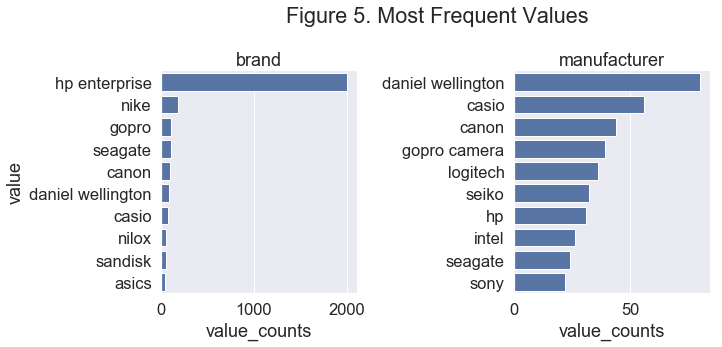

In [99]:
plt.figure(figsize=(50, 25))
g = sns.FacetGrid(top_values, col="variable", col_wrap=5, sharey=False, sharex=False)
g.fig.set_figwidth(25)
g.fig.set_figheight(5)
g.map(sns.barplot, 'value_counts', 'value')
g.set_titles("{col_name}") 
plt.subplots_adjust(top=.8)
g.fig.suptitle('Figure 5. Most Frequent Values', x=.25)
                    
plt.savefig("fig-05-brand-manufacturer-top-values.png", bbox_inches = "tight")
# https://stackoverflow.com/a/48208266/4463701

In [108]:
overlap = train_test_normalized_features[['brand', 'manufacturer']].dropna().apply(lambda x: x[0] == x[1], 1).value_counts()
overlap / overlap.sum()

True     0.779359
False    0.220641
dtype: float64

In [109]:
# count words
medium_long_features = train_test_normalized_features[MEDIUM_LONG_TEXT_FEATURES]
word_counts_df = medium_long_features.apply(count_words, axis=1)

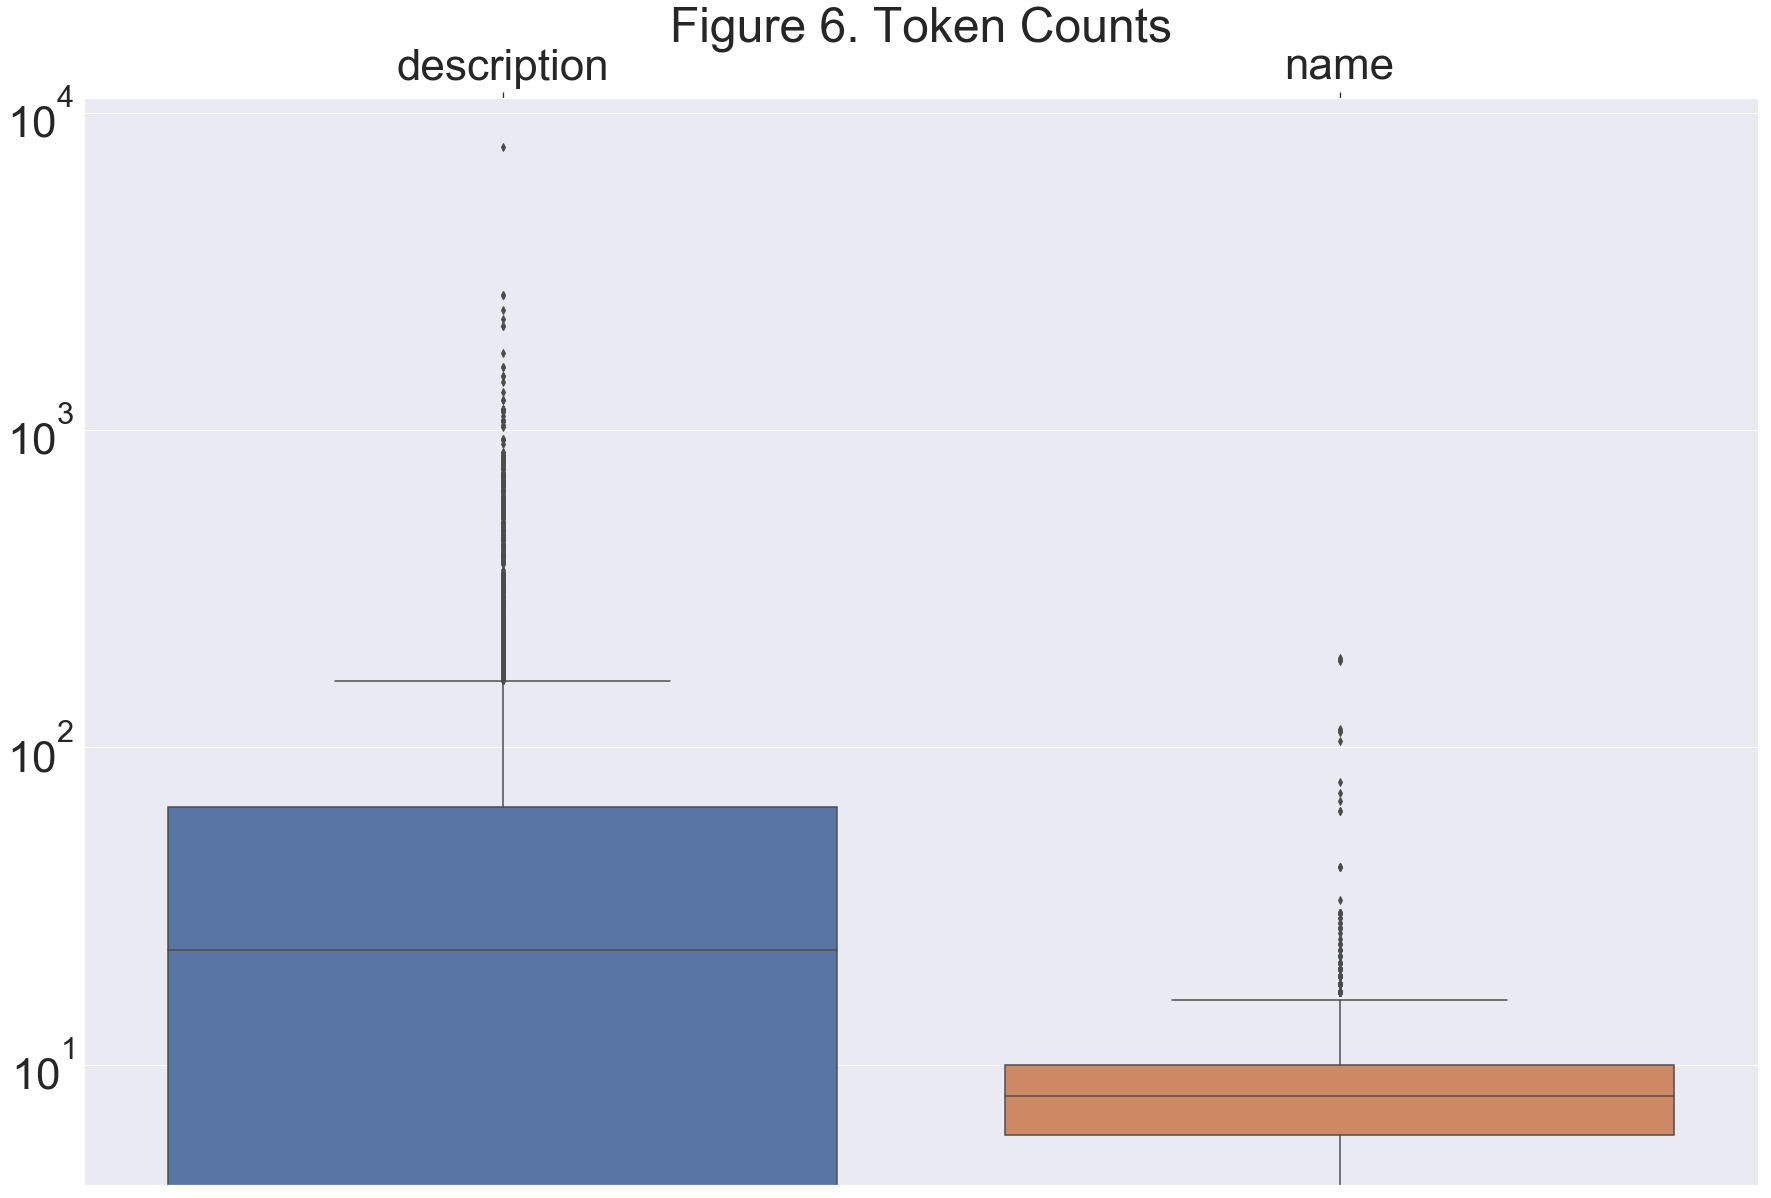

In [120]:
plt.figure(figsize=(30, 20))
sns.set(font_scale=4)

ax = sns.boxplot(data = word_counts_df)
ax.set_title('Figure 6. Token Counts')
ax.xaxis.tick_top()
ax.set(yscale='log')

plt.savefig("fig-06-name-descrition-word-counts.png", bbox_inches = "tight")

In [111]:
word_counts_df.median()

description    23.0
name            8.0
dtype: float64

### Training & Testing Data

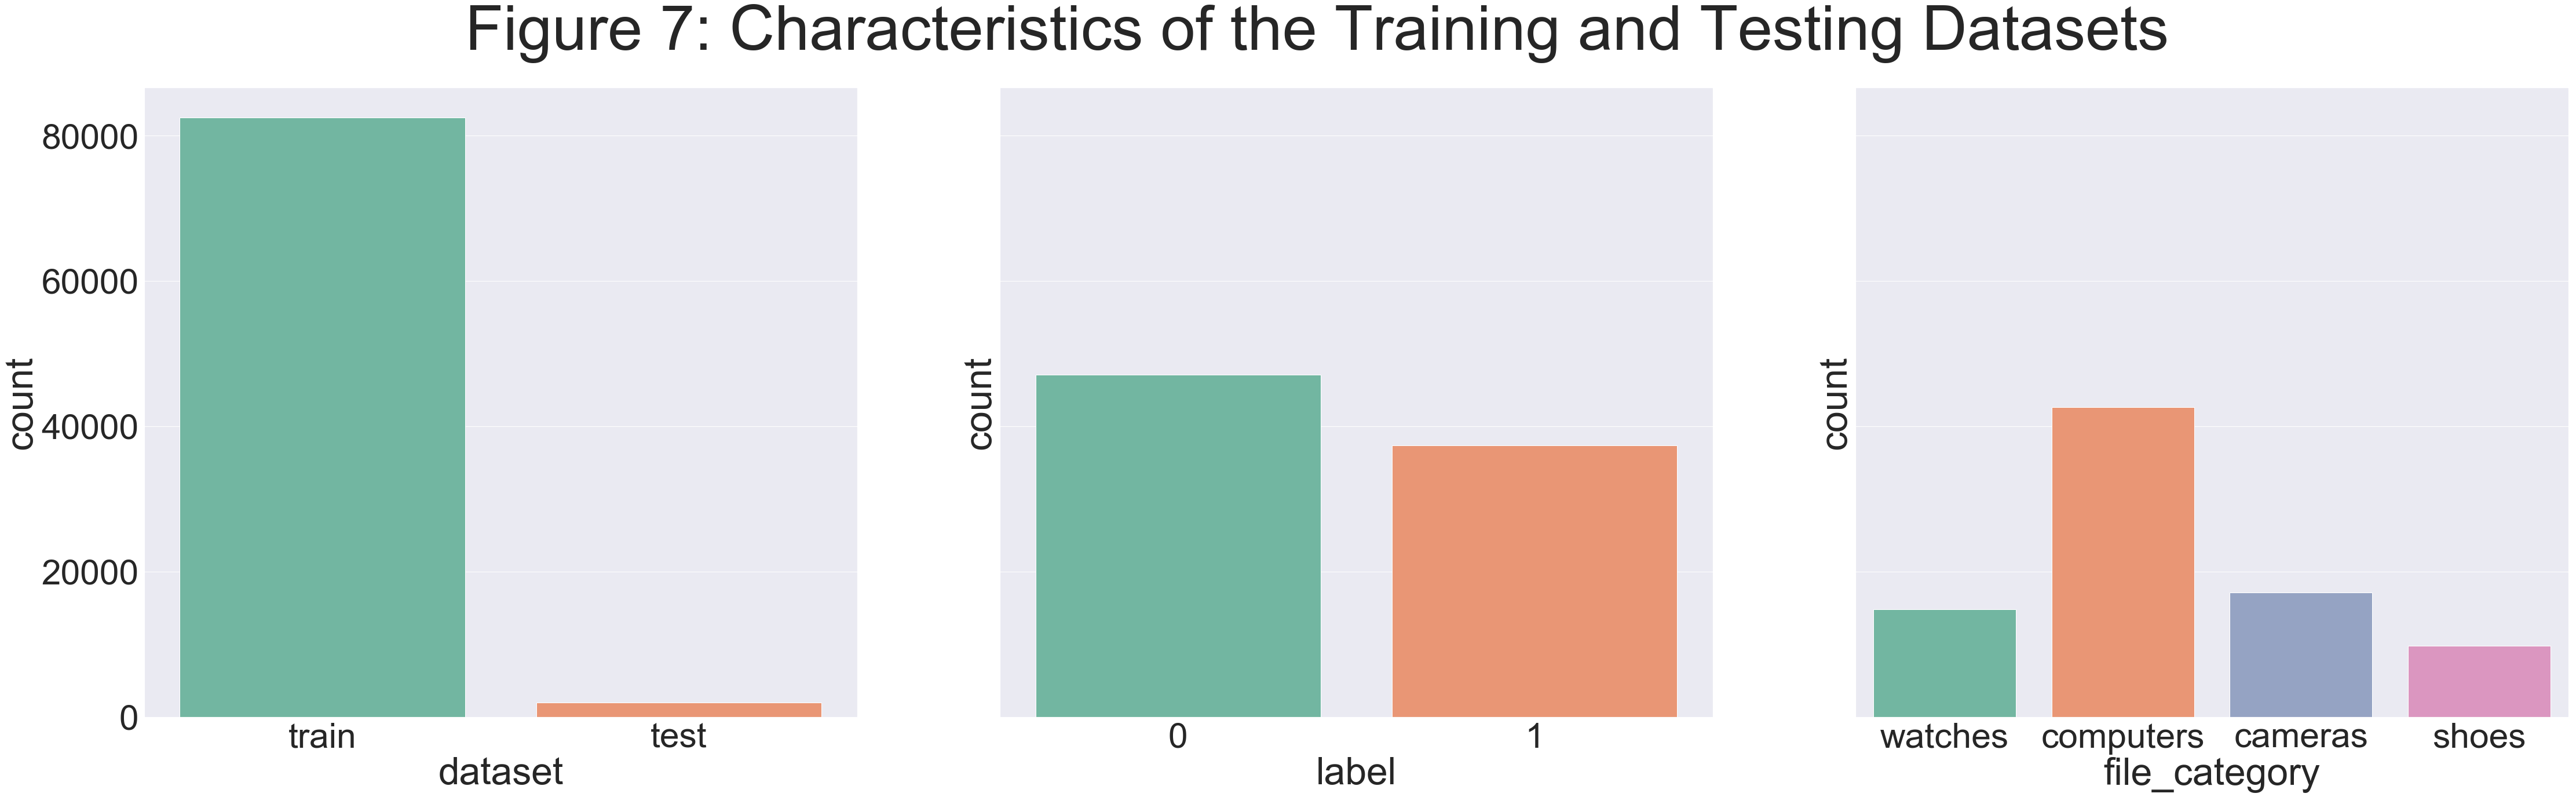

In [132]:
test_train_characteristics = train_test_feature_pairs[['label', 'dataset', 'file_category']]


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(75, 20), sharey=True) 

sns.set(font_scale=5.5)
plt.rcParams.update({'font.size': 90})
st = fig.suptitle("Figure 7: Characteristics of the Training and Testing Datasets")

sns.countplot(x='dataset', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[0])

sns.countplot(x='label', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[1])

sns.countplot(x='file_category', data=test_train_characteristics, palette=sns.color_palette("Set2"), ax=axes[2])

plt.savefig('fig-07-test-train-characteristics.png', bbox_inches = "tight")

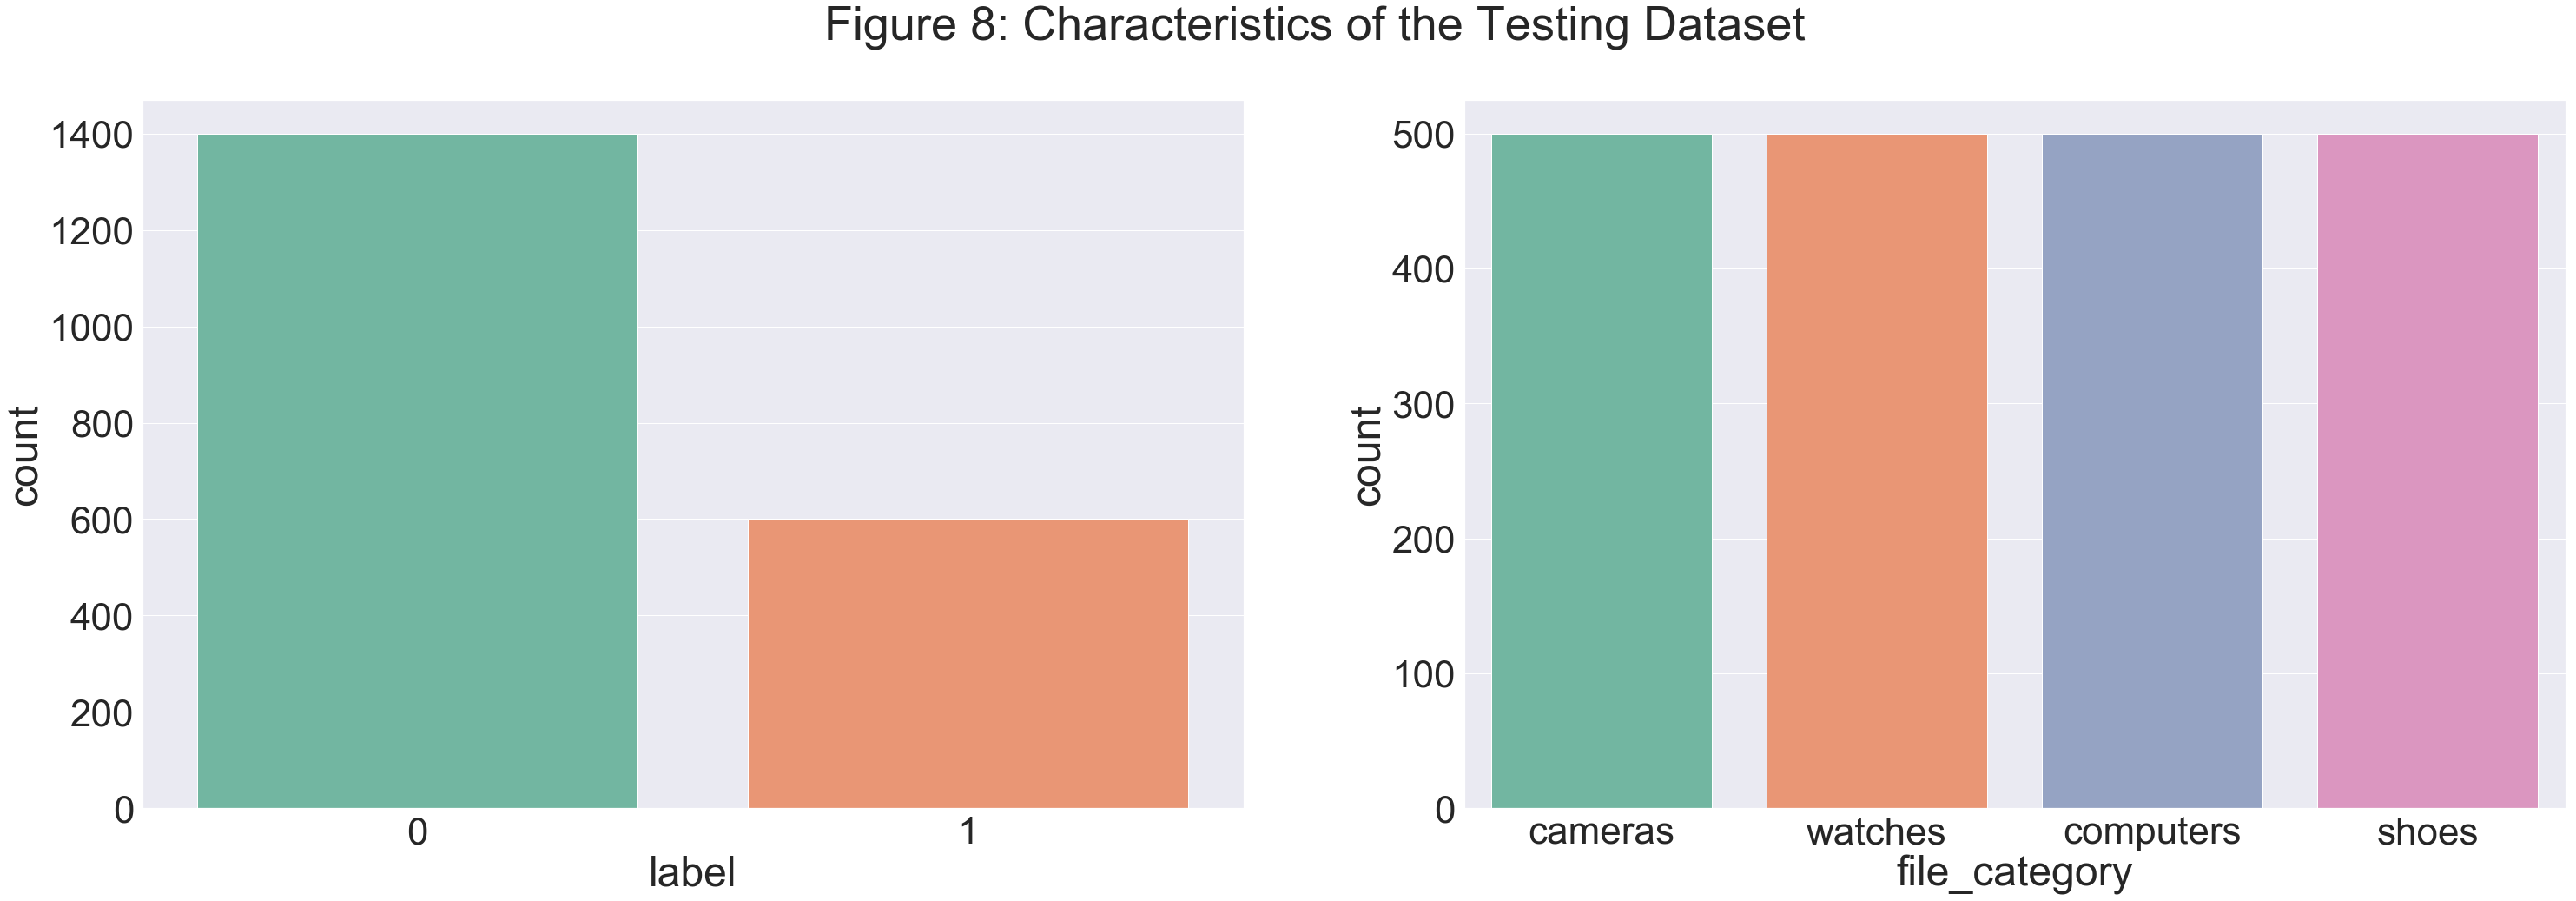

In [134]:
test_characteristics = test_train_characteristics[test_train_characteristics.dataset == 'test']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15)) #

sns.set(font_scale=4)
plt.rcParams.update({'font.size': 45})
st = fig.suptitle("Figure 8: Characteristics of the Testing Dataset")

sns.countplot(x='label', data=test_characteristics, palette=sns.color_palette("Set2"), ax=axes[0])

sns.countplot(x='file_category', data=test_characteristics, palette=sns.color_palette("Set2"), ax=axes[1])

plt.savefig('fig-08-test-set-characteristics.png')

In [11]:
test_matches = train_test_feature_pairs[(train_test_feature_pairs.label == 1) &
                                      (train_test_feature_pairs.dataset == 'test')][['file_category', 
                                                                                   'name_1', 
                                                                                   'name_2']]\
.sample(4, random_state=1)

pd.set_option('display.max_colwidth', 0)
h = HTML(test_matches.to_html(index=False))
display(h)

my_file = open('plots/table_1_matched_offer_pairs.html', 'w')
my_file.write(h.data)
my_file.close()

file_category,name_1,name_2
shoes,nike sportswear air force 1 07 white,sneakers buty nike air force 1 07 low white 315122 111
computers,323146 b21 bl20p g2 1p xeon 3 06ghz,323146 b21 bl20p xeon 3 06ghz
watches,daniel wellington dapper sheffield rose gold,daniel wellington men s dapper 38mm sheffield rose watch
cameras,canon eos rebel t5i,canon eos rebel t5i 18 135mm is stm digital slr camera kit black


# Offer Features




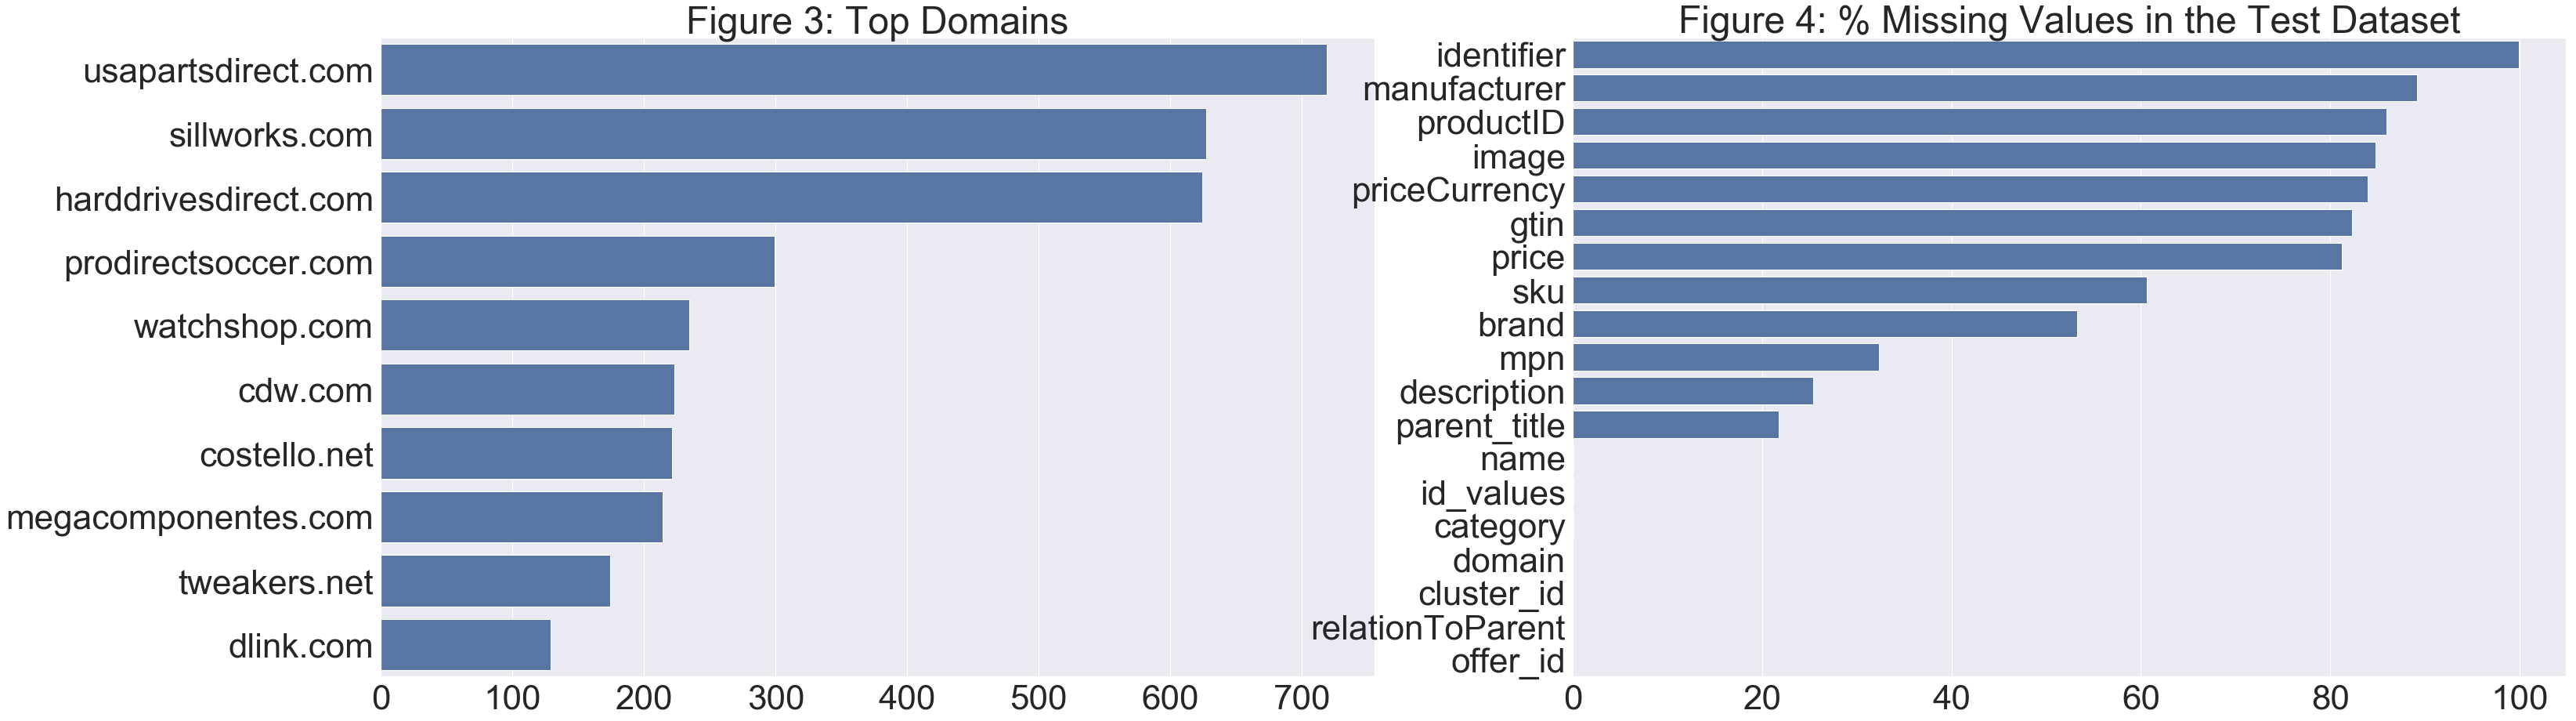

In [ ]:
# count words
name_length = train_test_offer_features.name.str.lower().str.split(expand=True).apply(lambda x: np.sum(pd.notnull(x)), 1).sort_values(ascending=False)
description_length = train_test_offer_features.description.str.lower().str.split(expand=True).apply(lambda x: np.sum(pd.notnull(x)), 1).sort_values(ascending=False)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50, 15), sharey=True)
sns.set(font_scale=4)

st = fig.suptitle("Figure 5: Number of Tokens in Name and Description Features")
sns.boxplot(y=name_length[20:].values, ax=axes[0]).set_title('Name')
sns.boxplot(y=description_length[500:].values, ax=axes[1]).set_title('Description')
fig.savefig("plots/name_description_tokens.png")

In [ ]:

print(np.median(name_length))
print(np.median(description_length))
description_length
train_test_offer_features.description[2:5].str.split(expand=True).apply(lambda x: np.sum(pd.notnull(x)), 1)

In [ ]:
sns.boxplot(y=description_length[1000:].values, ax=axes[1])

## Top Values by Attribute

In [21]:

train_test_normalized_features\
    .melt()\
    .dropna().groupby(['variable', 'value'])['value'].agg('count')\
    .to_frame()\
    .rename(index=str, columns={'value': 'value_counts'})\
    .reset_index()\
    .groupby(['variable'])\
    .apply(lambda x: x.nlargest(10, 'value_counts'))\
    .reset_index(drop=True)


NameError: name 'train_test_normalized_features' is not defined

In [ ]:
plt.figure(figsize=(11, 9))

offer_categories = train_test_offer_features.category.value_counts()
offer_categories_df = pd.DataFrame({'category': offer_categories.index, 'n': offer_categories})

sns.barplot(x='n', y='category', data=offer_categories_df)

sns.heatmap(train_test_offer_features[['brand', 'manufacturer']].isnull(), cbar=False)